# FatTailedTools: Examples

This notebook is meant to demonstrate the use of the various functions. As **case**, we will use the daily prices of the S&P500 index between 1950 and 2022. This case is in accordance to what is shown in the chapter *"It is what it is": Diagnosing the SP500* in the book *Statistical Consequences of Fat Tails* by Nassim N. Taleb, 2020. The data can, for example, be found on Yahoo Finance.

## 0. Load Data

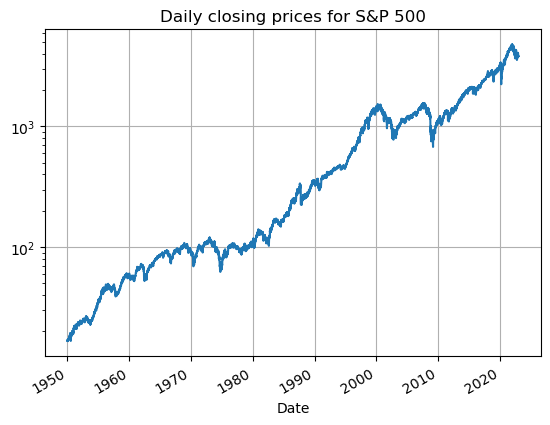

In [1]:
import pandas as pd

# Read daily prices of S&P500 from csv file
df = pd.read_csv(
    r'C:\Users\sevsad\OneDrive - SINTEF\Knowlegde Building\Friday Challenges\SP500.csv',
    index_col=[0], usecols=['Date', 'Close']
)

# Make sure the data is sorted
df.sort_index(inplace=True, ascending=True)

# Convert index to DateTimeIndex
df.index = pd.to_datetime(df.index)

# Use data between 1950 and 2022
series = df.loc['1950-01-01':'2022-12-31', 'Close']

# Visualize
series.plot(logy=True, grid=True, title='Daily closing prices for S&P 500');

## 1. Calculate Log Returns

In [2]:
from FatTailedTools import returns, tails

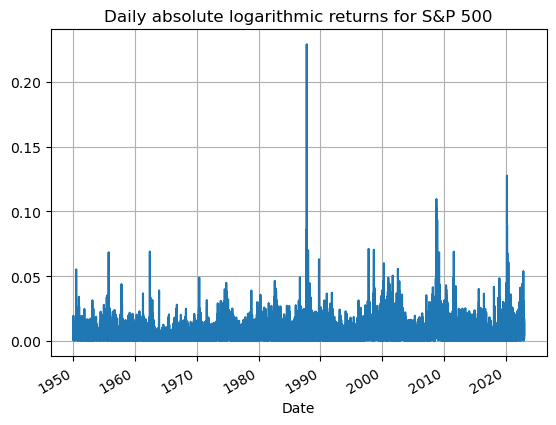

In [3]:
# Get logarithmic returns from daily closing prices of the S&P500 between 1950 and 2022
log_returns = returns.get_log_returns(series=series)

# Get absolute returns
log_returns_abs = tails.get_both_tails(log_returns)

# Get returns for left and right tails separately
log_returns_left  = tails.get_left_tail(log_returns)
log_returns_right = tails.get_right_tail(log_returns)

# Visualize
log_returns_abs.plot(grid=True, title='Daily absolute logarithmic returns for S&P 500');

## 2. Visual Identification of Paretianity

In [4]:
from FatTailedTools import plotting

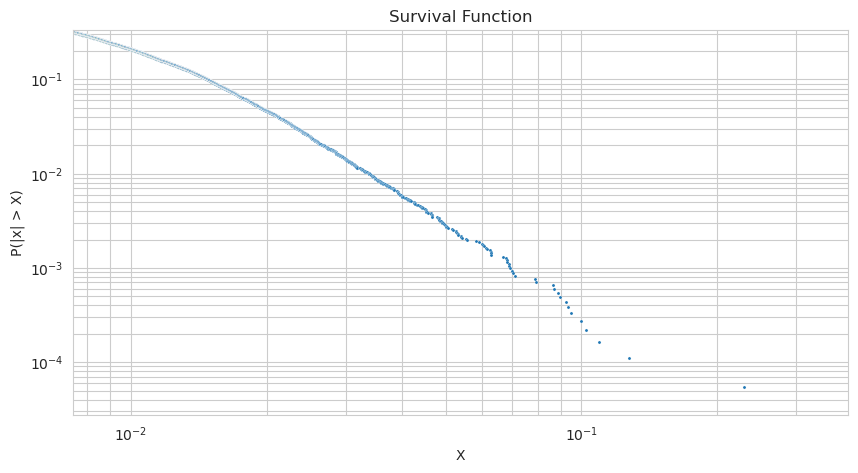

In [5]:
# Plot survival function for absolute returns
plotting.plot_survival_function(log_returns_abs, tail_zoom=True);

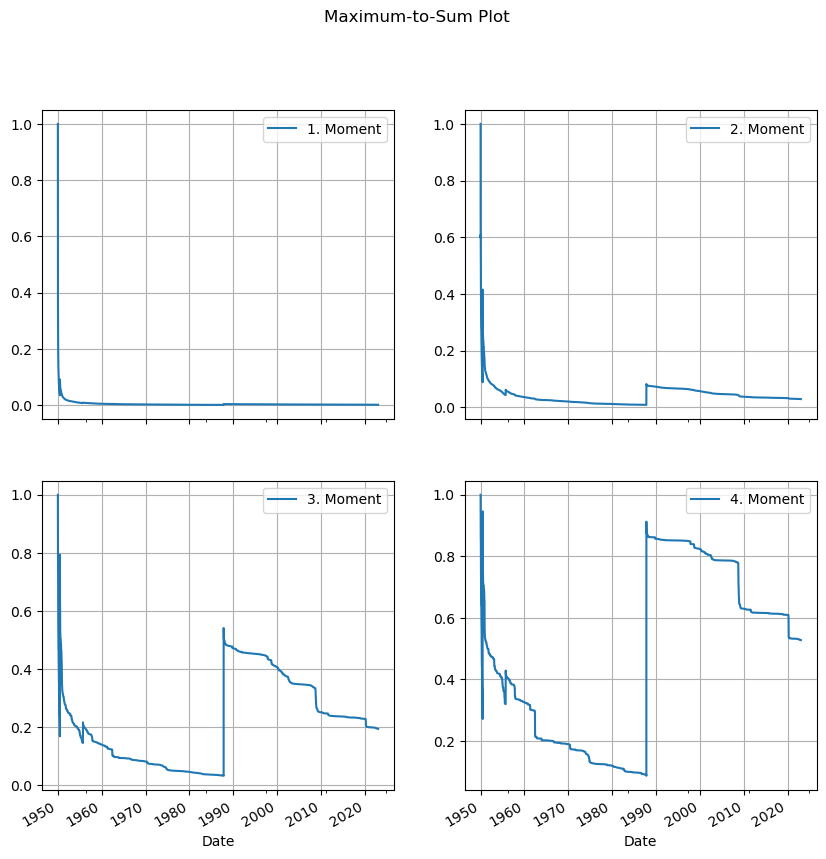

In [6]:
# Plot maximum-to-sum plot for the first 4 moments of the absolute log returns
plotting.max_sum_plot(log_returns_abs)